<a href="https://colab.research.google.com/github/Daksh-S97/HF-Audio/blob/main/HF_Audio.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install transformers datasets soundfile speechbrain accelerate librosa evaluate jiwer

In [ ]:
!pip install git+https://github.com/huggingface/transformers

In [2]:
from huggingface_hub import notebook_login
notebook_login()

## Unit 4

In [ ]:
# Load the dataset

from datasets import load_dataset

gtzan = load_dataset("marsyas/gtzan", 'all')

  0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
gtzan

DatasetDict({
    train: Dataset({
        features: ['file', 'audio', 'genre'],
        num_rows: 999
    })
})

In [ ]:
# train-test split
gtzan = gtzan["train"].train_test_split(seed=42, shuffle=True, test_size=0.1)
gtzan

DatasetDict({
    train: Dataset({
        features: ['file', 'audio', 'genre'],
        num_rows: 899
    })
    test: Dataset({
        features: ['file', 'audio', 'genre'],
        num_rows: 100
    })
})

In [ ]:
id2label_fn = gtzan["train"].features["genre"].int2str
id2label_fn(gtzan["train"][1]["genre"])

'classical'

In [ ]:
# load models
from transformers import AutoFeatureExtractor

d_hubert = "ntu-spml/distilhubert"
dhub_feature_extractor = AutoFeatureExtractor.from_pretrained(
    d_hubert, do_normalize=True, return_attention_mask=True
)

whisper = 'openai/whisper-medium.en'
whisper_feature_extractor = AutoFeatureExtractor.from_pretrained(
    whisper, do_normalize=True, return_attention_mask=True
)

ast = 'MIT/ast-finetuned-audioset-10-10-0.4593'
ast_feature_extractor = AutoFeatureExtractor.from_pretrained(
    ast, do_normalize=True
)

In [ ]:
ast_feature_extractor.sampling_rate

16000

In [ ]:
# down sample to the models' sampling rate(16kHz)
from datasets import Audio

gtzan = gtzan.cast_column("audio", Audio(sampling_rate=ast_feature_extractor.sampling_rate))

In [ ]:
#truncate to max_duration and normalize

max_duration = 30.0


def dhub_preprocess_function(examples):
    # feature_extractor = dhub_feature_extractor
    audio_arrays = [x["array"] for x in examples["audio"]]
    inputs = dhub_feature_extractor(
        audio_arrays,
        sampling_rate=dhub_feature_extractor.sampling_rate,
        max_length=int(dhub_feature_extractor.sampling_rate * max_duration),
        truncation=True,
        return_attention_mask=True,
    )
    return inputs

def whisper_preprocess_function(examples):
    feature_extractor = whisper_feature_extractor
    audio_arrays = [x["array"] for x in examples["audio"]]
    inputs = feature_extractor(
        audio_arrays,
        sampling_rate=feature_extractor.sampling_rate,
        max_length=int(feature_extractor.sampling_rate * max_duration),
        truncation=True,
        return_attention_mask=True,
    )
    return inputs

def ast_preprocess_function(examples):
    audio_arrays = [x["array"] for x in examples["audio"]]
    inputs = ast_feature_extractor(
        audio_arrays,
        sampling_rate=ast_feature_extractor.sampling_rate,
        max_length=int(ast_feature_extractor.sampling_rate * max_duration),
        truncation=True,
    )
    return inputs

In [ ]:
gtzan.cache_files

{'train': [{'filename': '/root/.cache/huggingface/datasets/marsyas___gtzan/all/0.0.0/8bd0e23c2d9b2be30d36bc6834319772dff22a3bd28527996612386cef003910/gtzan-train.arrow'},
  {'filename': '/root/.cache/huggingface/datasets/marsyas___gtzan/all/0.0.0/8bd0e23c2d9b2be30d36bc6834319772dff22a3bd28527996612386cef003910/cache-52d2398c8e4ac745.arrow'}],
 'test': [{'filename': '/root/.cache/huggingface/datasets/marsyas___gtzan/all/0.0.0/8bd0e23c2d9b2be30d36bc6834319772dff22a3bd28527996612386cef003910/gtzan-train.arrow'},
  {'filename': '/root/.cache/huggingface/datasets/marsyas___gtzan/all/0.0.0/8bd0e23c2d9b2be30d36bc6834319772dff22a3bd28527996612386cef003910/cache-3bcc56e346e4d81c.arrow'}]}

In [ ]:
# gtzan_preprocd = gtzan.map(
#     dhub_preprocess_function, remove_columns=["audio", "file"], batched=True, batch_size=2, writer_batch_size=2)
#ds_dhub = ds_dhub.rename_column("genre", "label")

# ds_wh = ds.map(
#     whisper_preprocess_function, remove_columns=["audio", "file"], batched=True, num_proc=1
# )
# ds_wh = ds_wh.rename_column("genre", "label")

gtzan_ast = gtzan.map(
    ast_preprocess_function, remove_columns=["audio", "file"], batched=True, num_proc=1, batch_size=2, writer_batch_size=2)
gtzan_ast = gtzan_ast.rename_column("genre", "label")

Map:   0%|          | 0/899 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

In [ ]:
gtzan_ast

DatasetDict({
    train: Dataset({
        features: ['label', 'input_values'],
        num_rows: 899
    })
    test: Dataset({
        features: ['label', 'input_values'],
        num_rows: 100
    })
})

In [ ]:
gtzan_ast['train'][0]['input_values']


In [ ]:
id2label = {
    str(i): id2label_fn(i)
    for i in range(len(gtzan_ast["train"].features["label"].names))
}
label2id = {v: k for k, v in id2label.items()}

id2label["7"]

'pop'

In [ ]:
from transformers import AutoModelForAudioClassification

num_labels = len(id2label)

model = AutoModelForAudioClassification.from_pretrained(
    ast,
    num_labels=num_labels,
    label2id=label2id,
    id2label=id2label,
    ignore_mismatched_sizes=True
)

Some weights of ASTForAudioClassification were not initialized from the model checkpoint at MIT/ast-finetuned-audioset-10-10-0.4593 and are newly initialized because the shapes did not match:
- classifier.dense.weight: found shape torch.Size([527, 768]) in the checkpoint and torch.Size([10, 768]) in the model instantiated
- classifier.dense.bias: found shape torch.Size([527]) in the checkpoint and torch.Size([10]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
!echo 'wtf'

wtf


In [ ]:
from transformers import TrainingArguments

model_name = "ast"
batch_size = 4
gradient_accumulation_steps = 1
num_train_epochs = 20

training_args = TrainingArguments(
    f"{model_name}-finetuned-gtzan",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=5e-5,
    lr_scheduler_type='linear',
    per_device_train_batch_size=batch_size,
    gradient_accumulation_steps=gradient_accumulation_steps,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=num_train_epochs,
    warmup_ratio=0.1,
    logging_steps=5,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    fp16=True,
    push_to_hub=True,
)

In [ ]:
!pip install evaluate

In [ ]:
import evaluate
import numpy as np
metric = evaluate.load("accuracy")


def compute_metrics(eval_pred):
    """Computes accuracy on a batch of predictions"""
    predictions = np.argmax(eval_pred.predictions, axis=1)
    return metric.compute(predictions=predictions, references=eval_pred.label_ids)

In [ ]:
from transformers import Trainer

trainer = Trainer(
    model,
    training_args,
    train_dataset=gtzan_ast["train"],
    eval_dataset=gtzan_ast["test"],
    tokenizer=ast_feature_extractor,
    compute_metrics=compute_metrics,
)

trainer.train()

/content/ast-finetuned-gtzan is already a clone of https://huggingface.co/model-man/ast-finetuned-gtzan. Make sure you pull the latest changes with `repo.git_pull()`.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.030000,0.721841,0.810000
2,0.300400,1.163913,0.800000
3,0.563300,0.883929,0.830000
4,0.035400,0.883881,0.800000
5,0.566600,1.115524,0.820000
6,0.000100,0.681296,0.900000
7,0.248200,0.684510,0.900000
8,0.000100,1.419618,0.800000
9,0.000000,0.960326,0.840000
10,0.000000,0.702982,0.880000


TrainOutput(global_step=4500, training_loss=0.06588212184884469, metrics={'train_runtime': 4460.607, 'train_samples_per_second': 4.031, 'train_steps_per_second': 1.009, 'total_flos': 1.2188224508657664e+18, 'train_loss': 0.06588212184884469, 'epoch': 20.0})

In [ ]:
kwargs = {
    "dataset_tags": "marsyas/gtzan",
    "dataset": "GTZAN",
    "model_name": "ast-finetuned-gtzan",
    "finetuned_from": ast,
    "tasks": "audio-classification",
}

In [ ]:
trainer.push_to_hub(**kwargs)

Upload file runs/Jul20_02-38-03_663018f36e95/events.out.tfevents.1689820690.663018f36e95.1045.4:   0%|        …

To https://huggingface.co/model-man/ast-finetuned-gtzan
   08350da..c42a259  main -> main

   08350da..c42a259  main -> main

To https://huggingface.co/model-man/ast-finetuned-gtzan
   c42a259..5c465a0  main -> main

   c42a259..5c465a0  main -> main



'https://huggingface.co/model-man/ast-finetuned-gtzan/commit/c42a2593986ae729189178b909612516c58ca229'

## Unit 5


In [ ]:
from datasets import load_dataset

ds = load_dataset('PolyAI/minds14', 'en-US')


Generating train split: 0 examples [00:00, ? examples/s]

Dataset minds14 downloaded and prepared to /root/.cache/huggingface/datasets/PolyAI___minds14/en-US/1.0.0/65c7e0f3be79e18a6ffaf879a083daf706312d421ac90d25718459cbf3c42696. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

1

In [ ]:
ds

DatasetDict({
    train: Dataset({
        features: ['path', 'audio', 'transcription', 'english_transcription', 'intent_class', 'lang_id'],
        num_rows: 563
    })
})

In [ ]:
len(ds['train'])

563

In [ ]:
x = ds['train'].select([i for i in range(450)])

In [ ]:
ds_2 = ds['train'].train_test_split(seed=42, test_size=0.2)
ds_2

DatasetDict({
    train: Dataset({
        features: ['path', 'audio', 'transcription', 'english_transcription', 'intent_class', 'lang_id'],
        num_rows: 450
    })
    test: Dataset({
        features: ['path', 'audio', 'transcription', 'english_transcription', 'intent_class', 'lang_id'],
        num_rows: 113
    })
})

In [ ]:
ds_2 = ds_2.select_columns(['audio', 'english_transcription'])

In [ ]:
from transformers.models.whisper.tokenization_whisper import TO_LANGUAGE_CODE

TO_LANGUAGE_CODE

In [ ]:
from transformers import WhisperProcessor

processor = WhisperProcessor.from_pretrained(
    "openai/whisper-small", language="english", task="transcribe"
)

In [ ]:
from datasets import Audio

sampling_rate = processor.feature_extractor.sampling_rate
ds_2= ds_2.cast_column("audio", Audio(sampling_rate=sampling_rate))

In [ ]:
ds_2

DatasetDict({
    train: Dataset({
        features: ['audio', 'english_transcription'],
        num_rows: 450
    })
    test: Dataset({
        features: ['audio', 'english_transcription'],
        num_rows: 113
    })
})

In [ ]:
def prepare_dataset(example):
    audio = example["audio"]

    example = processor(
        audio=audio["array"],
        sampling_rate=audio["sampling_rate"],
        text=example["english_transcription"],
    )

    # compute input length of audio sample in seconds
    example["input_length"] = len(audio["array"]) / audio["sampling_rate"]

    return example

In [ ]:
ds_2 = ds_2.map(
    prepare_dataset, remove_columns=ds_2.column_names["train"], num_proc=1, batch_size=2, writer_batch_size=2
)

Map:   0%|          | 0/450 [00:00<?, ? examples/s]

Map:   0%|          | 0/113 [00:00<?, ? examples/s]

In [ ]:
ds_2

DatasetDict({
    train: Dataset({
        features: ['input_features', 'labels', 'input_length'],
        num_rows: 450
    })
    test: Dataset({
        features: ['input_features', 'labels', 'input_length'],
        num_rows: 113
    })
})

In [ ]:
max_input_length = 30.0


def is_audio_in_length_range(length):
    return length < max_input_length

In [ ]:
ds_2["train"] = ds_2["train"].filter(
    is_audio_in_length_range,
    input_columns=["input_length"],
)

Filter:   0%|          | 0/450 [00:00<?, ? examples/s]

In [ ]:
ds_2

DatasetDict({
    train: Dataset({
        features: ['input_features', 'labels', 'input_length'],
        num_rows: 445
    })
    test: Dataset({
        features: ['input_features', 'labels', 'input_length'],
        num_rows: 113
    })
})

In [ ]:
import torch

from dataclasses import dataclass
from typing import Any, Dict, List, Union


@dataclass
class DataCollatorSpeechSeq2SeqWithPadding:
    processor: Any

    def __call__(
        self, features: List[Dict[str, Union[List[int], torch.Tensor]]]
    ) -> Dict[str, torch.Tensor]:
        # split inputs and labels since they have to be of different lengths and need different padding methods
        # first treat the audio inputs by simply returning torch tensors
        input_features = [
            {"input_features": feature["input_features"][0]} for feature in features
        ]
        batch = self.processor.feature_extractor.pad(input_features, return_tensors="pt")

        # get the tokenized label sequences
        label_features = [{"input_ids": feature["labels"]} for feature in features]
        # pad the labels to max length
        labels_batch = self.processor.tokenizer.pad(label_features, return_tensors="pt")

        # replace padding with -100 to ignore loss correctly
        labels = labels_batch["input_ids"].masked_fill(
            labels_batch.attention_mask.ne(1), -100
        )

        # if bos token is appended in previous tokenization step,
        # cut bos token here as it's append later anyways
        if (labels[:, 0] == self.processor.tokenizer.bos_token_id).all().cpu().item():
            labels = labels[:, 1:]

        batch["labels"] = labels

        return batch

In [ ]:
data_collator = DataCollatorSpeechSeq2SeqWithPadding(processor=processor)

In [ ]:
import evaluate

metric = evaluate.load("wer")

from transformers.models.whisper.english_normalizer import BasicTextNormalizer

normalizer = BasicTextNormalizer()


def compute_metrics(pred):
    pred_ids = pred.predictions
    label_ids = pred.label_ids

    # replace -100 with the pad_token_id
    label_ids[label_ids == -100] = processor.tokenizer.pad_token_id

    # we do not want to group tokens when computing the metrics
    pred_str = processor.batch_decode(pred_ids, skip_special_tokens=True)
    label_str = processor.batch_decode(label_ids, skip_special_tokens=True)

    # compute orthographic wer
    wer_ortho = metric.compute(predictions=pred_str, references=label_str)

    # compute normalised WER
    pred_str_norm = [normalizer(pred) for pred in pred_str]
    label_str_norm = [normalizer(label) for label in label_str]
    # filtering step to only evaluate the samples that correspond to non-zero references:
    pred_str_norm = [
        pred_str_norm[i] for i in range(len(pred_str_norm)) if len(label_str_norm[i]) > 0
    ]
    label_str_norm = [
        label_str_norm[i]
        for i in range(len(label_str_norm))
        if len(label_str_norm[i]) > 0
    ]

    wer = metric.compute(predictions=pred_str_norm, references=label_str_norm)

    return {"wer_ortho": wer_ortho, "wer": wer}

In [ ]:
from transformers import WhisperForConditionalGeneration

model = WhisperForConditionalGeneration.from_pretrained("openai/whisper-tiny")

In [ ]:
from functools import partial

# disable cache during training since it's incompatible with gradient checkpointing
model.config.use_cache = False

# set language and task for generation and re-enable cache
model.generate = partial(
    model.generate, language="english", task="transcribe", use_cache=True
)

In [ ]:
from transformers import Seq2SeqTrainingArguments

training_args = Seq2SeqTrainingArguments(
    output_dir="./whisper-tiny-dv",  # name on the HF Hub
    per_device_train_batch_size=16,
    gradient_accumulation_steps=1,  # increase by 2x for every 2x decrease in batch size
    learning_rate=1e-5,
    lr_scheduler_type="constant_with_warmup",
    warmup_steps=50,
    max_steps=500,
    gradient_checkpointing=True,
    fp16=True,
    fp16_full_eval=True,
    evaluation_strategy="steps",
    per_device_eval_batch_size=16,
    predict_with_generate=True,
    generation_max_length=225,
    save_steps=500,
    eval_steps=500,
    logging_steps=25,
    report_to=["tensorboard"],
    load_best_model_at_end=True,
    metric_for_best_model="wer",
    greater_is_better=False,
    push_to_hub=True,
)

In [ ]:
from transformers import Seq2SeqTrainer

trainer = Seq2SeqTrainer(
    args=training_args,
    model=model,
    train_dataset=ds_2["train"],
    eval_dataset=ds_2["test"],
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    tokenizer=processor,
)

trainer.train()

Cloning https://huggingface.co/model-man/whisper-tiny-dv into local empty directory.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss,Wer Ortho,Wer
500,0.000700,0.709758,0.357335,0.356589


TrainOutput(global_step=500, training_loss=0.34740809054672717, metrics={'train_runtime': 1419.2812, 'train_samples_per_second': 5.637, 'train_steps_per_second': 0.352, 'total_flos': 1.9569551781888e+17, 'train_loss': 0.34740809054672717, 'epoch': 17.86})

In [ ]:
kwargs = {
     "dataset_tags": "PolyAI/minds14",
    "finetuned_from": "openai/whisper-tiny",
    "tasks": "automatic-speech-recognition",
}

In [ ]:
trainer.push_to_hub(**kwargs)

To https://huggingface.co/model-man/whisper-tiny-dv
   881440f..da38d54  main -> main

   881440f..da38d54  main -> main

To https://huggingface.co/model-man/whisper-tiny-dv
   da38d54..81aa8ef  main -> main

   da38d54..81aa8ef  main -> main



'https://huggingface.co/model-man/whisper-tiny-dv/commit/da38d5423367fb3a37b0f48b10d0f55d8b427e1b'

## Unit 6

In [3]:
from datasets import load_dataset, Audio

dataset = load_dataset("facebook/voxpopuli", "hr", split="train")
len(dataset)

Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

10987

In [4]:
dataset = dataset.cast_column("audio", Audio(sampling_rate=16000))

In [5]:
from transformers import SpeechT5Processor

checkpoint = "microsoft/speecht5_tts"
processor = SpeechT5Processor.from_pretrained(checkpoint)

In [6]:
tokenizer = processor.tokenizer

In [7]:
dataset[0]

{'audio_id': '20180206-0900-PLENARY-15-hr_20180206-16:10:06_5',
 'language': 11,
 'audio': {'path': '/root/.cache/huggingface/datasets/downloads/extracted/36eee451a077e887d07f723523b81c3547979dbf205f681c2b78097f3b97cb00/train_part_0/20180206-0900-PLENARY-15-hr_20180206-16:10:06_5.wav',
  'array': array([-0.01434326, -0.01055908,  0.00106812, ...,  0.00646973,
          0.0116272 ,  0.00183105]),
  'sampling_rate': 16000},
 'raw_text': '',
 'normalized_text': 'poast genitalnog sakaenja ena u europi tek je jedna od manifestacija takve tetne politike.',
 'gender': 'female',
 'speaker_id': '119431',
 'is_gold_transcript': True,
 'accent': 'None'}

In [8]:
def extract_all_chars(batch):
    all_text = " ".join(batch["normalized_text"])
    vocab = list(set(all_text))
    return {"vocab": [vocab], "all_text": [all_text]}


vocabs = dataset.map(
    extract_all_chars,
    batched=True,
    batch_size=-1,
    keep_in_memory=True,
    remove_columns=dataset.column_names,
)

dataset_vocab = set(vocabs["vocab"][0])
tokenizer_vocab = {k for k, _ in tokenizer.get_vocab().items()}

Map:   0%|          | 0/10987 [00:00<?, ? examples/s]

In [9]:
dataset_vocab - tokenizer_vocab

{' ', 'á', 'ö', 'ü', 'ć', 'č', 'đ', 'š', 'ž'}

In [10]:
replacements = [
    ("á", "a"),
    ("ö", "o"),
    ("ü", "oo"),
    ("ć", "ch"),
    ("č", "ch"),
    ("đ", "g"),
    ("š", "sh"),
    ("ž", "j"),
]


def cleanup_text(inputs):
    for src, dst in replacements:
        inputs["normalized_text"] = inputs["normalized_text"].replace(src, dst)
    return inputs


dataset = dataset.map(cleanup_text)

Map:   0%|          | 0/10987 [00:00<?, ? examples/s]

In [11]:
from collections import defaultdict

speaker_counts = defaultdict(int)

for speaker_id in dataset["speaker_id"]:
    speaker_counts[speaker_id] += 1

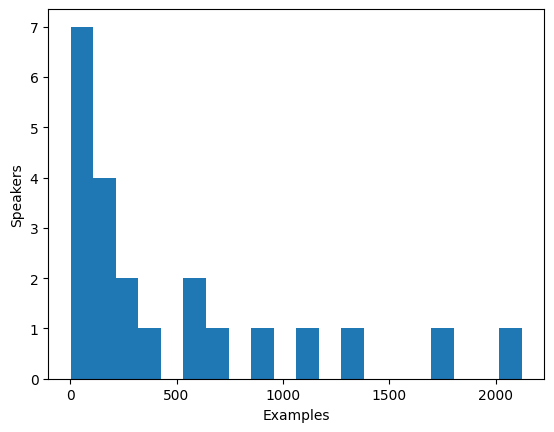

In [12]:
import matplotlib.pyplot as plt

plt.figure()
plt.hist(speaker_counts.values(), bins=20)
plt.ylabel("Speakers")
plt.xlabel("Examples")
plt.show()

In [19]:
def select_speaker(speaker_id):
    return 50 <= speaker_counts[speaker_id] <= 1000


dataset2 = dataset.filter(select_speaker, input_columns=["speaker_id"])

Filter:   0%|          | 0/10987 [00:00<?, ? examples/s]

In [20]:
len(set(dataset2["speaker_id"]))

15

In [21]:
len(dataset2)

4564

In [22]:
import os
import torch
from speechbrain.pretrained import EncoderClassifier

spk_model_name = "speechbrain/spkrec-xvect-voxceleb"

device = "cuda" if torch.cuda.is_available() else "cpu"
speaker_model = EncoderClassifier.from_hparams(
    source=spk_model_name,
    run_opts={"device": device},
    savedir=os.path.join("/tmp", spk_model_name),
)


def create_speaker_embedding(waveform):
    with torch.no_grad():
        speaker_embeddings = speaker_model.encode_batch(torch.tensor(waveform))
        speaker_embeddings = torch.nn.functional.normalize(speaker_embeddings, dim=2)
        speaker_embeddings = speaker_embeddings.squeeze().cpu().numpy()
    return speaker_embeddings

In [23]:
def prepare_dataset(example):
    audio = example["audio"]

    example = processor(
        text=example["normalized_text"],
        audio_target=audio["array"],
        sampling_rate=audio["sampling_rate"],
        return_attention_mask=False,
    )

    # strip off the batch dimension
    example["labels"] = example["labels"][0]

    # use SpeechBrain to obtain x-vector
    example["speaker_embeddings"] = create_speaker_embedding(audio["array"])

    return example

In [24]:
dataset2 = dataset2.map(prepare_dataset, remove_columns=dataset2.column_names)

Map:   0%|          | 0/4564 [00:00<?, ? examples/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (624 > 600). Running this sequence through the model will result in indexing errors


In [25]:
def is_not_too_long(input_ids):
    input_length = len(input_ids)
    return input_length < 200


dataset3 = dataset2.filter(is_not_too_long, input_columns=["input_ids"])
len(dataset3)

Filter:   0%|          | 0/4564 [00:00<?, ? examples/s]

2996

In [27]:
dataset3

Dataset({
    features: ['input_ids', 'labels', 'speaker_embeddings'],
    num_rows: 2996
})

In [28]:
dataset3 = dataset3.train_test_split(test_size=0.1)

In [29]:
from dataclasses import dataclass
from typing import Any, Dict, List, Union


@dataclass
class TTSDataCollatorWithPadding:
    processor: Any

    def __call__(
        self, features: List[Dict[str, Union[List[int], torch.Tensor]]]
    ) -> Dict[str, torch.Tensor]:
        input_ids = [{"input_ids": feature["input_ids"]} for feature in features]
        label_features = [{"input_values": feature["labels"]} for feature in features]
        speaker_features = [feature["speaker_embeddings"] for feature in features]

        # collate the inputs and targets into a batch
        batch = processor.pad(
            input_ids=input_ids, labels=label_features, return_tensors="pt"
        )

        # replace padding with -100 to ignore loss correctly
        batch["labels"] = batch["labels"].masked_fill(
            batch.decoder_attention_mask.unsqueeze(-1).ne(1), -100
        )

        # not used during fine-tuning
        del batch["decoder_attention_mask"]

        # round down target lengths to multiple of reduction factor
        if model.config.reduction_factor > 1:
            target_lengths = torch.tensor(
                [len(feature["input_values"]) for feature in label_features]
            )
            target_lengths = target_lengths.new(
                [
                    length - length % model.config.reduction_factor
                    for length in target_lengths
                ]
            )
            max_length = max(target_lengths)
            batch["labels"] = batch["labels"][:, :max_length]

        # also add in the speaker embeddings
        batch["speaker_embeddings"] = torch.tensor(speaker_features)

        return batch

In [30]:
data_collator = TTSDataCollatorWithPadding(processor=processor)

In [31]:
from transformers import SpeechT5ForTextToSpeech

model = SpeechT5ForTextToSpeech.from_pretrained(checkpoint)

In [32]:
from functools import partial

# disable cache during training since it's incompatible with gradient checkpointing
model.config.use_cache = False

# set language and task for generation and re-enable cache
model.generate = partial(model.generate, use_cache=True)

In [36]:
from transformers import Seq2SeqTrainingArguments

training_args = Seq2SeqTrainingArguments(
    output_dir="speecht5_finetuned_voxpopuli_hr",  # change to a repo name of your choice
    per_device_train_batch_size=4,
    gradient_accumulation_steps=8,
    learning_rate=1e-5,
    warmup_steps=200,
    max_steps=2000,
    gradient_checkpointing=True,
    fp16=True,
    evaluation_strategy="steps",
    per_device_eval_batch_size=2,
    save_steps=500,
    eval_steps=500,
    logging_steps=25,
    report_to=["tensorboard"],
    load_best_model_at_end=True,
    greater_is_better=False,
    label_names=["labels"],
    push_to_hub=True,
)

In [37]:
from transformers import Seq2SeqTrainer

trainer = Seq2SeqTrainer(
    args=training_args,
    model=model,
    train_dataset=dataset3["train"],
    eval_dataset=dataset3["test"],
    data_collator=data_collator,
    tokenizer=processor,
)

/content/speecht5_finetuned_voxpopuli_hr is already a clone of https://huggingface.co/model-man/speecht5_finetuned_voxpopuli_hr. Make sure you pull the latest changes with `repo.git_pull()`.


In [38]:
trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss
500,0.508500,0.467367
1000,0.486400,0.453777
1500,0.482900,0.449428
2000,0.478500,0.447701


TrainOutput(global_step=2000, training_loss=0.5064179487228394, metrics={'train_runtime': 5377.8072, 'train_samples_per_second': 11.901, 'train_steps_per_second': 0.372, 'total_flos': 9326543373683712.0, 'train_loss': 0.5064179487228394, 'epoch': 23.74})

In [39]:
trainer.push_to_hub()

Upload file runs/Jul28_07-32-54_c4c84518867b/events.out.tfevents.1690529581.c4c84518867b.159.1: 100%|#########…

To https://huggingface.co/model-man/speecht5_finetuned_voxpopuli_hr
   54c598f..7283149  main -> main

   54c598f..7283149  main -> main

To https://huggingface.co/model-man/speecht5_finetuned_voxpopuli_hr
   7283149..d57bb99  main -> main

   7283149..d57bb99  main -> main



'https://huggingface.co/model-man/speecht5_finetuned_voxpopuli_hr/commit/7283149fe266a9eb822a1628de15a1a77ccc62c2'